In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterstats import zonal_stats
from tqdm import tqdm

## Check the area of one pixel


In [2]:
# Check the area of one pixel
with rasterio.open(
    "../data/sufosat/forest-clearcuts_mainland-france_sufosat_dates_v3.tif"
) as src:
    # Get pixel size (resolution) from the transform
    pixel_width, pixel_height = src.res  # (width, height)

    # Calculate the pixel area in square meters
    pixel_area = pixel_width * pixel_height

    print(pixel_width, pixel_height)

9.99999999999999 10.0


In [3]:
PIXEL_AREA = 100  # 100 m²

## Calculate statistics on the full raster data


In [4]:
def load_clear_cut_dates() -> pd.Series:
    nonzero = []
    with rasterio.open(
        "../data/sufosat/forest-clearcuts_mainland-france_sufosat_dates_v3.tif"
    ) as src:
        # Read the data as a generator (window-by-window) to avoid out Of memory issues
        # since the total grid contains billions of points
        for _, window in tqdm(
            src.block_windows(),
            total=src.width * src.height // (src.block_shapes[0][0] * src.block_shapes[0][1]),
        ):
            # Read the block data for the first and only band
            data = src.read(1, window=window)

            # Only keep nonzero values
            nonzero.append(data[data != 0])

    # Concatenate the nonzero values from each window in a single array
    sufosat_dates = np.concatenate(nonzero)

    # Extract year and days using NumPy operations
    years = 2000 + sufosat_dates // 1000
    days = (sufosat_dates % 1000) - 1

    # Create a Pandas Timestamp array
    dates = pd.to_datetime({"year": years, "month": 1, "day": 1}) + pd.to_timedelta(
        days, unit="D"
    )

    # Convert to Pandas Series
    sufosat = pd.Series(dates)

    return sufosat


sufosat = load_clear_cut_dates()
sufosat

231136it [00:56, 4077.90it/s]                            


0          2023-04-24
1          2023-04-24
2          2023-02-08
3          2023-02-08
4          2023-04-24
              ...    
56908885   2019-12-25
56908886   2019-12-25
56908887   2019-12-25
56908888   2019-12-25
56908889   2019-12-25
Length: 56908890, dtype: datetime64[ns]

In [5]:
pixels_per_month = sufosat.dt.to_period("M").value_counts().sort_index()
pixels_per_month

2017-10      2976
2017-11     22450
2017-12     58323
2018-01    153579
2018-02     64658
            ...  
2024-09    245929
2024-10    174992
2024-11     88716
2024-12     57036
2025-01     13940
Freq: M, Name: count, Length: 88, dtype: int64

In [6]:
# 1 ha = 10000 m²
hectares_per_month = pixels_per_month * PIXEL_AREA / 10000
hectares_per_month

2017-10      29.76
2017-11     224.50
2017-12     583.23
2018-01    1535.79
2018-02     646.58
            ...   
2024-09    2459.29
2024-10    1749.92
2024-11     887.16
2024-12     570.36
2025-01     139.40
Freq: M, Name: count, Length: 88, dtype: float64

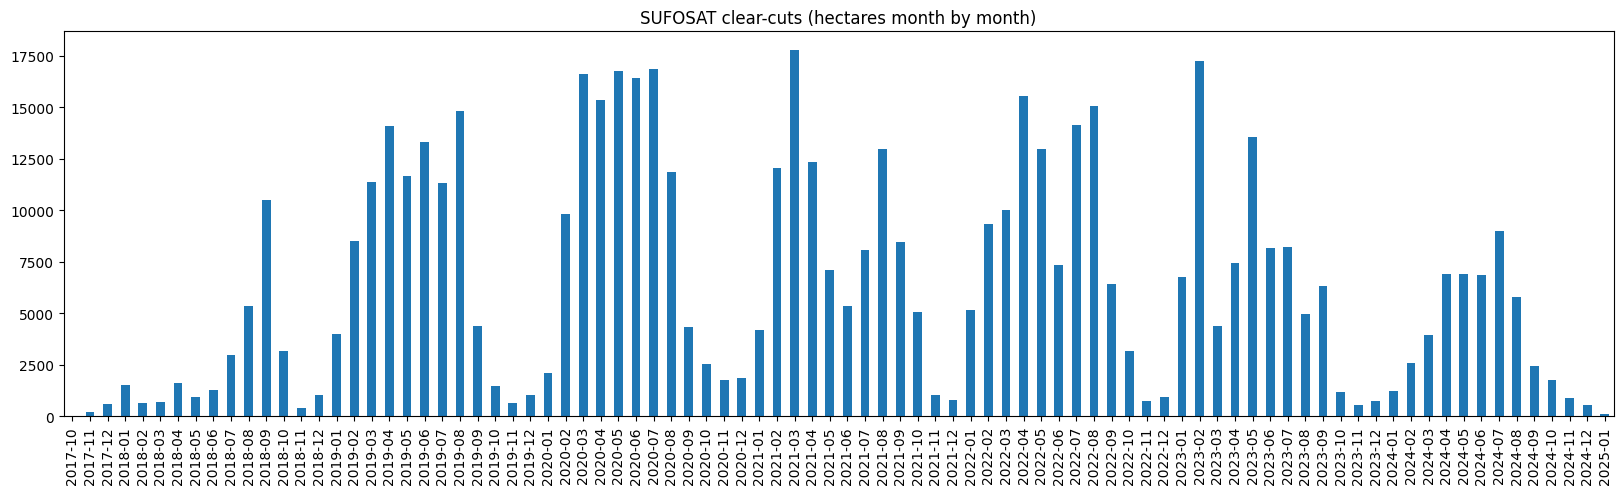

In [7]:
hectares_per_month.plot.bar(
    figsize=(20, 5), title="SUFOSAT clear-cuts (hectares month by month)"
);

## Calculate statistics on a subset of the raster data with a polygon mask


In [8]:
natura2000 = gpd.read_file("../data/natura2000")
natura2000

,SITECODE,SITENAME,Aire_m2,Aire_km2,Couches,geometry
0,FR1110025,Etang de Saint Quentin,9.613632e+05,0.961363,ZPS,"POLYGON ((627623.168 6854888.067, 627620.379 6..."
1,FR1110795,Massif de Fontainebleau,2.805923e+08,280.592252,ZPS,"MULTIPOLYGON (((686304.526 6806792.984, 686243..."
2,FR1112001,Massif de Villefermoy,4.783470e+07,47.834702,ZPS,"MULTIPOLYGON (((699069.343 6818948.132, 698740..."
3,FR1112002,Bassée et plaines adjacentes,2.760597e+08,276.059669,ZPS,"MULTIPOLYGON (((729943.243 6825377.977, 730620..."
4,FR1112003,Boucles de la Marne,2.638088e+07,26.380880,ZPS,"MULTIPOLYGON (((714834.051 6873595.418, 714786..."
...,...,...,...,...,...,...
1757,FR7200749,Montagnes du Barétous,1.442144e+08,144.214366,ZSC,"MULTIPOLYGON (((400290.475 6227215.38, 400583...."
1758,FR7200752,Massif des Arbailles,1.278352e+08,127.835215,ZSC,"MULTIPOLYGON (((370428.867 6238736.854, 370575..."
1759,FR7200750,Montagnes de la Haute Soule,1.436027e+08,143.602745,ZSC,"MULTIPOLYGON (((383161.014 6223904.758, 383354..."
1760,FR9101413,Posidonies de la côte palavasienne,1.080703e+08,108.070324,ZSC,"POLYGON ((764008.157 6255745.243, 762998.071 6..."


In [9]:
# Some Natura2000 zones overlap (between ZPS and ZSC)
# We cannot count pixels with overlaping polygons because this would lead us to counting pixels more than once
# For simplicity, I'll just union all the polygons
# If there's no overlap, we can use the geodataframe geometries directly
natura2000_polygons = natura2000.union_all()

In [10]:
# Count the pixels for each Natura2000 polygon
pixels_count_per_polygon = zonal_stats(
    natura2000_polygons.geoms,  # List of polygons
    raster="../data/sufosat/forest-clearcuts_mainland-france_sufosat_dates_v3.tif",
    categorical=True,
)

In [11]:
# For each polygon, we have the pixels count
print(len(pixels_count_per_polygon))
print(pixels_count_per_polygon[0])

7349
{17275: 1, 17279: 3, 17280: 8, 17286: 15, 17298: 62, 17299: 21, 17304: 3, 17310: 12, 17311: 9, 17316: 3, 17322: 2, 17323: 1, 17327: 11, 17334: 2, 17335: 10, 17339: 5, 17346: 101, 17347: 33, 17351: 101, 17358: 184, 17359: 482, 17363: 693, 17364: 552, 18005: 423, 18006: 324, 18010: 952, 18011: 668, 18017: 1, 18018: 4, 18022: 73, 18023: 61, 18029: 2, 18030: 11, 18034: 186, 18035: 71, 18041: 38, 18042: 43, 18046: 79, 18047: 64, 18053: 200, 18054: 97, 18058: 5, 18059: 2, 18065: 687, 18066: 416, 18077: 4920, 18078: 3055, 18084: 62, 18089: 1064, 18090: 621, 18094: 23, 18096: 88, 18101: 88, 18102: 88, 18106: 11, 18113: 235, 18114: 820, 18118: 288, 18120: 5, 18125: 75, 18126: 329, 18130: 472, 18132: 6, 18137: 48, 18138: 283, 18142: 107, 18144: 4, 18149: 94, 18150: 106, 18154: 42, 18161: 115, 18162: 159, 18166: 29, 18168: 21, 18173: 57, 18174: 218, 18178: 100, 18185: 93, 18186: 342, 18190: 75, 18192: 10, 18197: 155, 18198: 321, 18202: 55, 18204: 2, 18209: 330, 18210: 699, 18214: 139, 18221:

In [12]:
# Summing values from all dictionaries
sum_dict = {}
for d in pixels_count_per_polygon:
    for key, value in d.items():
        sum_dict[key] = sum_dict.get(key, 0) + value

sufosat_natura2000 = pd.Series(sum_dict).sort_index()
sufosat_natura2000

17275     93
17276      4
17277     19
17278     29
17279     46
        ... 
25012    170
25013    245
25014    111
25016     74
25019    103
Length: 2486, dtype: int64

In [13]:
years = 2000 + sufosat_natura2000.index // 1000
days = (sufosat_natura2000.index % 1000) - 1

# Create a Pandas Timestamp array
dates = pd.to_datetime({"year": years, "month": 1, "day": 1}) + pd.to_timedelta(days, unit="D")

sufosat_natura2000.index = dates
sufosat_natura2000

2017-10-02     93
2017-10-03      4
2017-10-04     19
2017-10-05     29
2017-10-06     46
             ... 
2025-01-12    170
2025-01-13    245
2025-01-14    111
2025-01-16     74
2025-01-19    103
Length: 2486, dtype: int64

In [14]:
pixels_per_month = sufosat_natura2000.groupby(sufosat_natura2000.index.to_period("M")).sum()
pixels_per_month

2017-10     2037
2017-11    11393
2017-12    39190
2018-01    99466
2018-02    27160
           ...  
2024-09    32649
2024-10    18208
2024-11    11639
2024-12    15311
2025-01     3561
Freq: M, Length: 88, dtype: int64

In [15]:
# 1 ha = 10000 m²
hectares_per_month = pixels_per_month * PIXEL_AREA / 10000
hectares_per_month

2017-10     20.37
2017-11    113.93
2017-12    391.90
2018-01    994.66
2018-02    271.60
            ...  
2024-09    326.49
2024-10    182.08
2024-11    116.39
2024-12    153.11
2025-01     35.61
Freq: M, Length: 88, dtype: float64

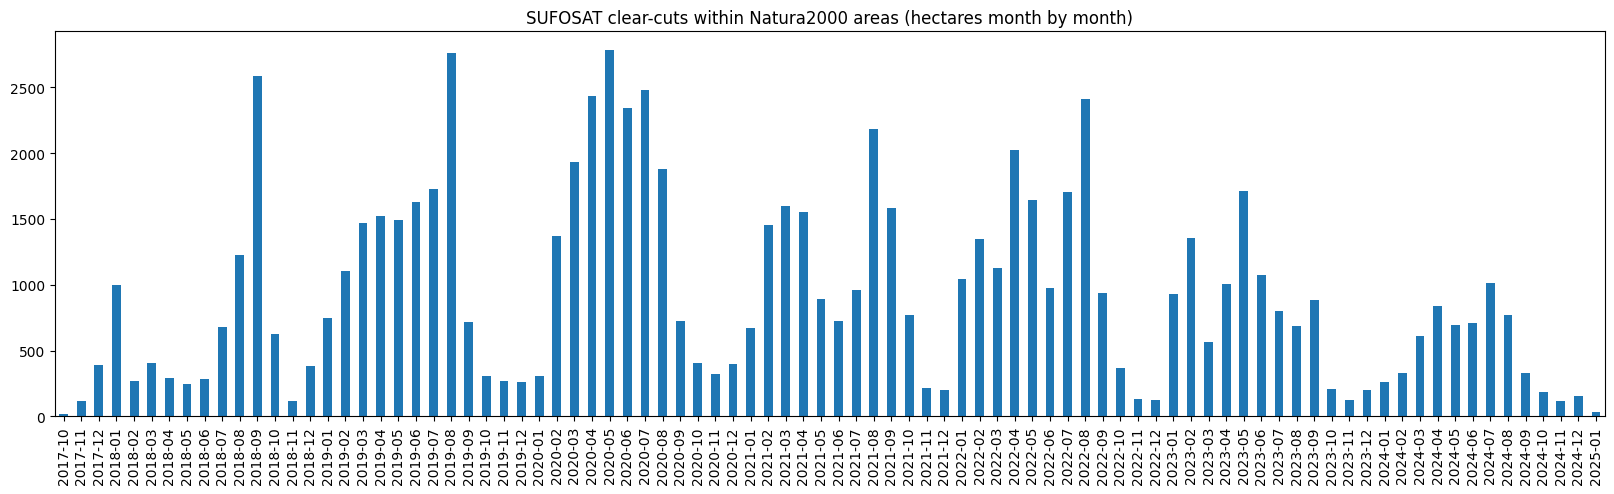

In [20]:
hectares_per_month.plot.bar(
    figsize=(20, 5),
    title="SUFOSAT clear-cuts within Natura2000 areas (hectares month by month)",
);